
<center><img src="https://miro.medium.com/max/1000/1*Q7sZcfRj2M64GDD1ncvoCA.jpeg" width="60%" height="#"></center>

## Imports



In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import mnist

## Preprocessing

### Load dataset

In [2]:
(X_train, _),(X_test, _) = mnist.load_data()

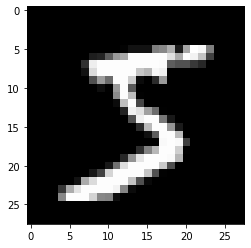

In [3]:
X_real = np.concatenate((X_train, X_test))

plt.imshow(X_real[0], cmap="gray")

### Data normalization

In [4]:
X_real = X_real / 255.0

print(X_real.shape)

(70000, 28, 28)


In [5]:
X_real = np.reshape(X_real,(-1,28,28,1))
print(X_real.shape)

(70000, 28, 28, 1)


## Learning

### Building Discriminator

A discriminator that tells how real an image is, is basically a deep Convolutional Neural Network (CNN). For MNIST Dataset, the input is an image (28 pixel x 28 pixel x 1 channel). The sigmoid output is a scalar value of the probability of how real the image is (0.0 is certainly fake, 1.0 is certainly real, anything in between is a gray area).

The difference from a typical CNN is the absence of max-pooling in between layers. Instead, a strided convolution is used for downsampling. The activation function used in each CNN layer is a leaky ReLU. A dropout between 0.4 and 0.7 between layers prevent over fitting and memorization.

<img src="https://miro.medium.com/max/1400/1*QHMGABbwL04x5VGYc_UWSA.png" width="60%" height="#">

In [6]:
X_input = tf.keras.layers.Input(shape=(28,28,1))
X = tf.keras.layers.Conv2D(filters=64, kernel_size=(5,5), strides=(2,2), padding='same', activation=tf.keras.layers.LeakyReLU(alpha=0.2))(X_input)
X = tf.keras.layers.Dropout(0.4)(X)
X = tf.keras.layers.Conv2D(filters=128, kernel_size=(5,5), strides=(2,2), padding='same', activation=tf.keras.layers.LeakyReLU(alpha=0.2))(X)
X = tf.keras.layers.Dropout(0.4)(X)
X = tf.keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(2,2), padding='same', activation=tf.keras.layers.LeakyReLU(alpha=0.2))(X)
X = tf.keras.layers.Dropout(0.4)(X)
X = tf.keras.layers.Conv2D(filters=512, kernel_size=(5,5), strides=(1,1), padding='same', activation=tf.keras.layers.LeakyReLU(alpha=0.2))(X)
X = tf.keras.layers.Dropout(0.4)(X)
X = tf.keras.layers.Flatten()(X)
D = tf.keras.layers.Dense(1, activation='sigmoid')(X)

discriminator = tf.keras.models.Model(inputs=X_input, outputs=D)
discriminator.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.RMSprop(lr=0.0008, clipvalue=1.0, decay=6e-8), metrics=['accuracy'])

discriminator.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 256)         819456    
_________________________________________________________________
dropout_2 (Dropout)          (None, 4, 4, 256)         0     

### Building Generator

The generator synthesizes fake images. The fake image is generated from a 100-dimensional noise (uniform distribution between -1.0 to 1.0) using the transposed convolution. Instead of fractionally-strided convolution as suggested in DCGAN, upsampling between the first three layers is used since it synthesizes more realistic handwriting images. 

In between layers, batch normalization stabilizes learning. The activation function after each layer is a ReLU. The output of the sigmoid at the last layer produces the fake image. Dropout of between 0.3 and 0.5 at the first layer prevents overfitting.

<img src="https://miro.medium.com/max/1400/1*gvBT3h4JD7eUN0GexHwx2w.png" width="60%" height="#">

In [7]:
X_embedding = tf.keras.layers.Input(shape=(100))
X = tf.keras.layers.Dense(7*7*256, kernel_initializer='glorot_normal', activation='relu')(X_embedding)
X = tf.keras.layers.BatchNormalization(momentum=0.9)(X)
X = tf.keras.layers.Reshape((7,7,256))(X)
X = tf.keras.layers.Dropout(0.4)(X)
X = tf.keras.layers.UpSampling2D()(X)
X = tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=(5,5), padding='same', activation='relu')(X)
X = tf.keras.layers.BatchNormalization(momentum=0.9)(X)
X = tf.keras.layers.UpSampling2D()(X)
X = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=(5,5), padding='same', activation='relu')(X)
X = tf.keras.layers.BatchNormalization(momentum=0.9)(X)
X = tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=(5,5), padding='same', activation='relu')(X)
X = tf.keras.layers.BatchNormalization(momentum=0.9)(X)
G = tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=(5,5), padding='same', activation='sigmoid')(X)

generator = tf.keras.models.Model(inputs=X_embedding, outputs=G)
generator.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.001), metrics='accuracy')

generator.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 12544)             1266944   
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 7, 7, 256)         0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 256)       0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 128)       8193

In [8]:
# Build stacked GAN model
X_embedding = tf.keras.layers.Input(shape=(100))
X = generator(X_embedding)
A = discriminator(X)

adversarial = tf.keras.models.Model(X_embedding, A)
adversarial.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.001), metrics='accuracy')

adversarial.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
model_1 (Model)              (None, 28, 28, 1)         2394241   
_________________________________________________________________
model (Model)                (None, 1)                 4311553   
Total params: 6,705,794
Trainable params: 6,680,258
Non-trainable params: 25,536
_________________________________________________________________


### Train

Training is the hardest part. First we train the Discriminator model alone with real and fake images.

<center><img src="https://miro.medium.com/max/1400/1*N3nT9AXVnsFBta2R1eEMjg.png" width="60%" height="#"></center>



In [9]:
def sample_real(nsamples):

  # generate samples from real images
  random_gen = np.random.randint(0, 60000, nsamples)
  X_real_samples = X_real[random_gen, :, :, :]
  y_real_samples = np.ones(nsamples)

  return X_real_samples, y_real_samples

def sample_fake(nsamples):
  # generate samples from fake images
  noise_gen = np.random.uniform(0,1,size=[nsamples,100])
  X_fake_samples = generator.predict(noise_gen)
  y_fake_samples = np.zeros(nsamples)

  return X_fake_samples, y_fake_samples

In [10]:
def show_real(X_real_samples):
  plt.figure(figsize=(10,10))
  for i in range(1,11):
    plt.subplot(1, 10, i)
    plt.imshow(X_real_samples[i].reshape(28,28), cmap="gray")
    plt.axis('off')
  plt.tight_layout()
  plt.show()

def show_fake(X_fake_samples):
  plt.figure(figsize=(10,10))
  for i in range(1,11):
    plt.subplot(1, 10, i)
    plt.imshow(X_fake_samples[i].reshape(28,28), cmap="gray")
    plt.axis('off')
  plt.tight_layout()
  plt.show() 

(100, 28, 28, 1)
(100,)
[1. 1. 1. 1. 1. 1. 1. 1. 1.]
(100, 28, 28, 1)
(100,)
[0. 0. 0. 0. 0. 0. 0. 0. 0.]


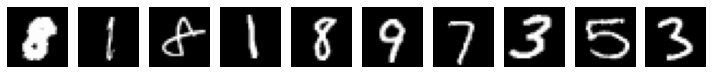

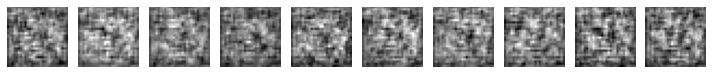

In [11]:
X_real_samples, y_real_samples = sample_real(100)
X_fake_samples, y_fake_samples = sample_fake(100)

print(X_real_samples.shape)
print(y_real_samples.shape)
print(y_real_samples[1:10])

print(X_fake_samples.shape)
print(y_fake_samples.shape)
print(y_fake_samples[1:10])

show_real(X_real_samples)
show_fake(X_fake_samples)

Afterwards, the Discriminator and Adversarial models are trained one after the other.

In [12]:
from IPython import display

def plot_loss(losses):
  plt.figure(figsize=(10,8))
  plt.plot(losses["d"], label='discriminitive loss')
  plt.plot(losses["a"], label='generative loss')
  plt.legend()
  plt.show()

In [13]:
losses = {"d":[], "a":[]}

def train(train_steps=20, batch_size=128, plt_frq=20):
  for i in range(train_steps): 

    print("---Discriminator update---")
    for j in range(4):
      # sample minibatch of m noise samples {z(1),...,z(m)} from noise prior pg(z)
      X_fake_samples, y_fake_samples = sample_fake(batch_size)

      # sample minibatch of m examples {x(1),..., x(m)} from data generating distribution pdata(x)
      X_real_samples, y_real_samples = sample_real(batch_size)

      # concatenate samples
      X = np.concatenate((X_real_samples, X_fake_samples))
      y = np.concatenate((y_real_samples, y_fake_samples))

      # update the discriminator by ascending its stochastic gradient (remember maximizing log likelihood is the same as minimizing negative log likelihood)
      d_history = discriminator.fit(X, y, epochs=1, batch_size=batch_size)
      #d_loss, d_acc  = discriminator.train_on_batch(X, y)
    losses["d"].append(d_history.history['loss'][0])
    #losses["d"].append(d_loss)
      

    print("---Adversarial update---")
    # sample minibatch of m noise samples {z(1),..., z(m)} from noise prior pg(z)
    noise_gen = np.random.uniform(0,1,size=[batch_size,100])

    # update the generator by descending its stochastic gradient 
    # flip labels and minimize cross entropy (force the discriminator to output high probability for real if an image is fake))
    y_fake_samples = np.ones(batch_size)   
    
    a_history = adversarial.fit(noise_gen, y_fake_samples, epochs=1, batch_size=batch_size)
    #a_loss, a_acc = adversarial.train_on_batch(noise_gen, y_fake_samples)
    losses["a"].append(a_history.history['loss'][0])
    #losses["a"].append(a_loss)

    if i % plt_frq==plt_frq-1:
      print("---Logging---")
      display.clear_output(wait=True)
      display.display(plt.gcf())
      show_fake(X_fake_samples)
      plot_loss(losses)

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

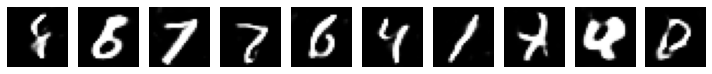

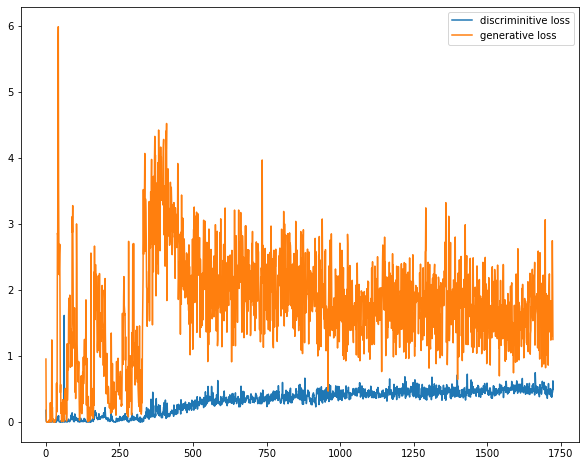

---Discriminator update---
2/2 [==============================] - 0s 9ms/step - loss: 0.5206 - accuracy: 0.7656
---Adversarial update---
1/1 [==============================] - 0s 816us/step - loss: 1.7833 - accuracy: 0.2031
---Discriminator update---
2/2 [==============================] - 0s 9ms/step - loss: 0.5057 - accuracy: 0.7461
---Adversarial update---
1/1 [==============================] - 0s 873us/step - loss: 2.1448 - accuracy: 0.0469
---Discriminator update---
2/2 [==============================] - 0s 9ms/step - loss: 0.5379 - accuracy: 0.6992
---Adversarial update---
1/1 [==============================] - 0s 919us/step - loss: 1.0108 - accuracy: 0.4297
---Discriminator update---
1/2 [==============>...............] - ETA: 0s - loss: 0.5791 - accuracy: 0.7422

In [ ]:
train(train_steps=2000)

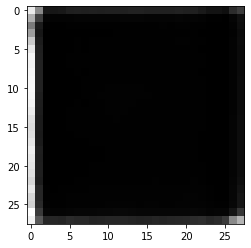

In [19]:
noise_gen = np.random.uniform(0,1,size=[1,100])
X_fake_new = generator.predict(noise_gen)

plt.imshow(X_fake_new[0].reshape((28,28)), cmap="gray")